# 自学习

| 更新时间 | 负责人 | 内容 | 备注 |
| --- | --- | --- | --- |
| 2022年1月4日 | Rui | 初次编写文档 | ---- |
| 2022年1月8日 | dianjixz | 修改文档的编写方式 | 使用 Jupyter notebook 进行编写文档 |
| 2022年1月18日 | Rui | 修改文档，增加效果图 | 通过测试的平台有 MaixII-Dock，使用的是 MaixPy3 0.4.0 |

## 运行效果

<p align="center">
  <iframe src="//player.bilibili.com/player.html?aid=808318247&bvid=BV1C34y1i7QZ&cid=487776187&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true" style="max-width:640px; max-height:480px;"> </iframe>
</p>

## 准备

- 在 [MaixHub](https://www.maixhub.com/modelInfo?modelId=24) 上获取模型文件和运行源码（最新版本的系统内置了模型文件 `/home/model/resnet18_1000_awnn*`）
- 确认 MaixPy3 版本为 0.4.3 以上
- 使用的硬件为 MaixII-Dock
- 内存卡内是最新版本的镜像系统
- 插卡启动硬件

## 自学习训练与保存

将模型读取到python环境中！

In [1]:
from maix import nn
from maix import camera, display
import time

global Self_learn
class Self_learn:
    model = {
        "param": "/home/model/resnet18_1000_awnn.param",
        "bin": "/home/model/resnet18_1000_awnn.bin"
    }
    options = {
        "model_type":  "awnn",
        "inputs": {
            "input0": (224, 224, 3)
        },
        "outputs": {
            "190": (1, 1, 512)
        },
        "mean": [127.5, 127.5, 127.5],
        "norm": [0.0176, 0.0176, 0.0176],
    }
    class_num = 3  #学习类别
    sample_num = 15  #学习类别总数量
    curr_class = 0
    curr_sample = 0    
    def __init__(self):
        from maix import nn
        from maix.nn.app.classifier import Classifier
        print("-- load model:", self.model)
        self.m = nn.load(self.model, opt=self.options)
        print("-- load ok")
        print("-- load classifier")
        self.classifier = Classifier(self.m, self.class_num, self.sample_num, 512, 224, 224)
        print("-- load ok")


[ rpyc-kernel ]( running at Thu Jan 20 09:45:15 2022 )
-- load model: {'param': '/home/model/resnet18_1000_awnn.param', 'bin': '/home/model/resnet18_1000_awnn.bin'}
-- load ok
-- load classifier
-- load ok


### 添加分类的类别
通过摄像头拍摄物体2秒来进行添加，当画面卡住不动的时候，就需要移动到下一个类别等待摄像头启动，进行添加

> 一下代码只能添加3个类别，模型是没有上限的

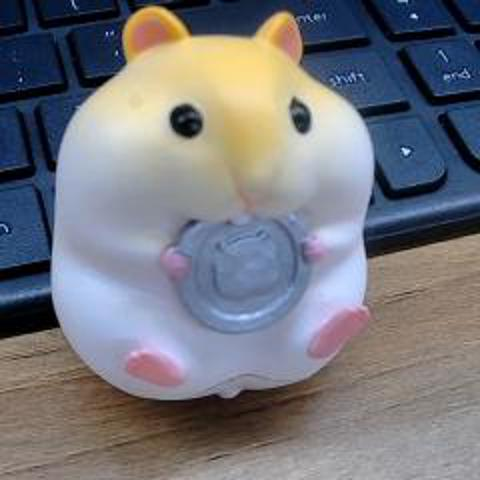

add ok!


In [1]:
import time
from maix import camera, display
global self_learn
self_learn = Self_learn()
for x in range(3):
    t = time.time()
    while True:
        if (time.time() - t) > 2:
            img = camera.capture().resize(224, 224)
            self_learn.classifier.add_class_img(img)
            display.show(img)
            time.sleep(2)
            print("add ok!")
            break
        img = camera.capture()
        display.show(img)


### 制作模型训练的数据集

运行代码之后，通过每个物品给摄像头拍摄2秒，当画面卡住不动的时候就可以移动下一个物品，进行拍摄数据集

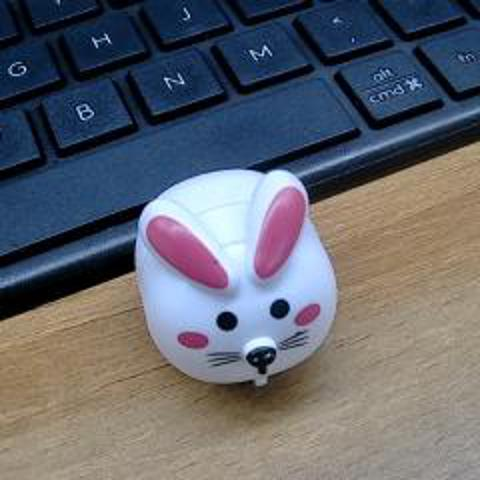

In [1]:
import time
from maix import nn
from maix import camera, display

for x in range(3):
    t = time.time()
    while True:
        if (time.time() - t) > 2:
            for i in range(5):
                img = camera.capture().resize(224, 224)
                self_learn.classifier.add_sample_img(img)
                display.show(img)
            time.sleep(2)
            break
        display.show(camera.capture())

进行图片自学习

In [1]:
self_learn.classifier.train()
print("train over")

[ rpyc-kernel ]( running at Thu Jan 20 09:31:48 2022 )


训练结束后保存模型

In [1]:
self_learn.classifier.save("./module.bin")
print("save over")

[ rpyc-kernel ]( running at Wed Jan 19 15:43:36 2022 )


开始进行分类验证

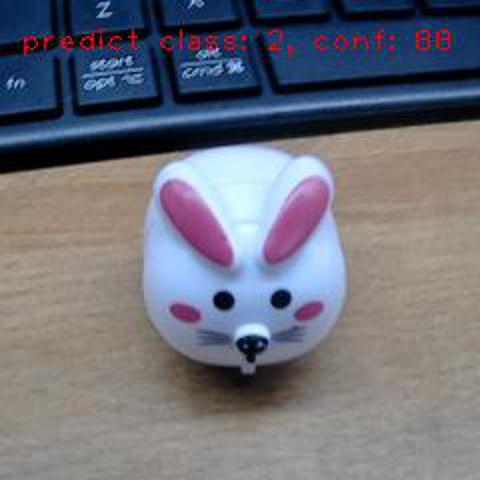

predict class: 2, conf: 88



Traceback (most recent call last):
  File "<string>", line unknown, in <module>
Remote.KeyboardInterrupt


In [1]:
import time
from maix import nn
from maix import camera, display
while True:
    img = camera.capture()
    AI_img = img.copy().resize(224, 224)
    idx, distance = self_learn.classifier.predict(AI_img)
    msg = "predict class: " + str(idx+1) + ", conf: " + str(100-distance)
    print(msg)
    img.draw_string(10, 10, msg, color = (255, 0, 0))  
    display.show(img)

## 读取自学习模型

In [1]:
global Self_learn
class Self_learn:
    model = {
        "param": "/home/model/resnet18_1000_awnn.param",
        "bin": "/home/model/resnet18_1000_awnn.bin"
    }
    options = {
        "model_type":  "awnn",
        "inputs": {
            "input0": (224, 224, 3)
        },
        "outputs": {
            "190": (1, 1, 512)
        },
        "mean": [127.5, 127.5, 127.5],
        "norm": [0.0176, 0.0176, 0.0176],
    }
    class_num = 3  #学习类别
    sample_num = 15  #学习类别总数量
    curr_class = 0
    curr_sample = 0    
    def __init__(self):
        from maix import nn
        from maix.nn.app.classifier import Classifier
        from maix.nn.app.classifier import load
        import os.path
        if os.path.isfile("./module.bin"):
            print("-- load model:", self.model)
            self.m = nn.load(self.model, opt=self.options)
            print("-- load ok")
            print("-- load classifier")
            self.classifier = load(self.m,"./module.bin")
            print("-- load ok")
        else:
            print("not have model!")
            print("please run nn_self_learn_classifier.py get model!")
print(Self_learn)

[ rpyc-kernel ]( running at Wed Jan 19 15:44:46 2022 )
-- load model: {'param': '/home/model/resnet18_1000_awnn.param', 'bin': '/home/model/resnet18_1000_awnn.bin'}
-- load ok
-- load classifier
-- load ok


自学习预测

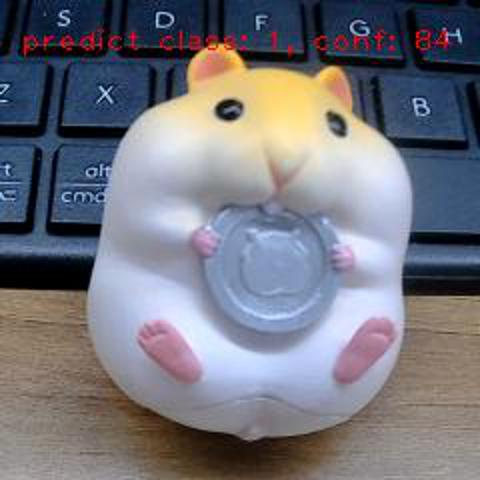


Traceback (most recent call last):
  File "<string>", line unknown, in <module>
Remote.KeyboardInterrupt


In [1]:
import time
from maix import camera, display
global self_learn
self_learn = Self_learn()
while True:
    img = camera.capture()
    AI_img = img.copy().resize(224, 224)
    idx, distance = self_learn.classifier.predict(AI_img)
    msg = "predict class: " + str(idx+1) + ", conf: " + str(100-distance)
    # print(msg)
    img.draw_string(10, 10, msg, color = (255, 0, 0))
    display.show(img)